
# Demonstration Viewer

This notebook is for viewing and processing demonstrations so that they can be used for servoing. This has two main components. The first is subsampling the trajectory to obtain a set of keysteps for which we want to do servoing. It is not necessary to servo to all intermediate states, this increases the speed of servoing dramatically.

The second is computing a foregreound segmentation mask. This is needed in order to be able to focus on the objects of interested and to avoid being confounded by various other objects.

Script Arguments:

    recording: the directory in which the recording is located. Should include:
        `frame_000000.npz`
        `camera_info.npz`
   
Returns:
    `servo_keep.json`
    `servo_mask.json`
    

# Setup

First we start by loading the demonstration.

In [1]:
import os
import numpy as np
import logging

def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True  # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False  # Probably standard Python interpreter

interactive = is_notebook()  # becomes overwritten
if interactive:
    get_ipython().run_line_magic('matplotlib', 'notebook')
    from ipywidgets import widgets, interact, Layout
    import matplotlib.pyplot as plt

# Load Demonstration

In [3]:
import copy
import json
from tqdm import tqdm

from robot_io.envs.playback_env import PlaybackEnv
from robot_io.recorder.simple_recorder import unprocess_seg

if interactive:    
    # set parameters here
    #recording = "../tmp_test/pick_n_place/"
    #recording = "../tmp_test/shape_sorting_trapeze_rR/"
    recording = "/tmp/flow_experiments/shape_sorting_trapeze_rR_seed017/"
    #recording = "/home/argusm/CLUSTER/robot_recordings/flow/sick_wtt/16-51-30"
    recording = "/home/argusm/Desktop/Demonstrations/car/15-58-30"
else:
    # expect commandline input
    import sys
    if len(sys.argv) != 3:
        print("Usage: Demonstration_Viewer.py <episode_dir>")
    recording = sys.argv[1]

if not os.path.isdir(recording):
    ValueError(f"Recording directory not found: {recording}")

segment_conf_fn = os.path.join(recording, "segment_conf.json")
keep_fn = os.path.join(recording, f"servo_keep.json")
mask_fn = os.path.join(recording, f"servo_mask.npz")

try:
    with open(segment_conf_fn, "r") as f_obj:
        orig_seg_conf = json.load(f_obj)
        if type(orig_seg_conf["objects"]) == list:
            orig_seg_conf["objects"] = orig_seg_conf["objects"][0]
        seg_conf = copy.deepcopy(orig_seg_conf)
except FileNotFoundError:
    seg_conf = None

In [5]:
from flow_control.demo.playback_env_servo import PlaybackEnvServo
playback = PlaybackEnvServo(recording)
rec = PlaybackEnv(recording)

WARNING - 2023-03-03 13:27:37,733 - playback_env_servo - Couldn't find servoing keyframes: /home/argusm/Desktop/Demonstrations/car/15-58-30/servo_keep.json, servoing will take ages


In [7]:
tcp_pos = []
tcp_orn = []
gripper_width = []
gripper_actions = []
video_recording = []
for i in range(len(rec)):
    video_recording.append(rec[i].data["rgb_gripper"])
    tcp_pos.append(rec[i].data["robot_state"].item()["tcp_pos"])
    tcp_orn.append(rec[i].data["robot_state"].item()["tcp_orn"])
    gripper_width.append(rec[i].data["robot_state"].item()["gripper_opening_width"])
#     ipdb.set_trace()
    try:
        gripper_actions.append(rec[i].data["action"].item().gripper_action)
    except:
        gripper_actions.append(1)
            
gripper_width = np.array(gripper_width)
gripper_actions = np.array(gripper_actions)
tcp_pos = np.array(tcp_pos)
tcp_orn = np.array(tcp_orn)
    
assert gripper_width.ndim == 1
gripper_width = np.array(gripper_width, dtype=float)
percent_invalid = np.sum(np.isnan(gripper_width))/len(gripper_width)
if percent_invalid > .1:
    logging.warning("gripper positions are not valid")
    gripper_width_valid = False
else:
    gripper_width_valid = True


masks_sim_l = []
move_anchors = []
wp_names = []
for rec_el in rec:
    rec_info = rec_el.data["info"].item()
    
    if "seg_mask" in rec_info:
        tmp = unprocess_seg(rec_info["seg_mask"])[0]
        masks_sim_l.append(tmp)
    else:
        masks_sim_l.append(None)
    
    if "move_anchor" in rec_info:
        move_anchors.append(rec_info["move_anchor"])
    else:
        move_anchors.append(None)
    
    if "wp_name" in rec_info:
        wp_names.append(rec_info["wp_name"])
    else:
        wp_names.append("")

masks_sim = np.array(masks_sim_l)
if np.all(masks_sim == None):
    masks_sim = None

num_frames = len(rec)
max_frame = num_frames-1

print(f"loaded segmentation masks {np.sum([s is not None for s in masks_sim_l])}/{num_frames}" )
print(f"loaded move_anchors {np.sum([a is not None for a in move_anchors])}/{num_frames}" )
print(f"loaded waypoint names {np.sum([wp !='' for wp in wp_names])}/{num_frames}")
    
print("loaded.")

loaded segmentation masks 0/47
loaded move_anchors 0/47
loaded waypoint names 1/47
loaded.


# 1. Compute Keep Steps 

Decide which frames to keep, this information is saved as a dictionary whos keys are the frame index.

There are several possible sources of information to use when deciding which frames to keep.

1. The waypoint names. If these are provided they show when a motion segment ends.
2. Gripper action and state. Segment by the state of the gripper, also keep only those where gripper is stable.
3. TCP motion. Find those frames where movement is minimal.

In [8]:
# use actions here instead of state position recordings as these
# are more direct and reliable, but in general try to use states
# as these are less suceptible to problems
gripper_change_steps = np.where(np.diff(gripper_actions))[0].tolist()

# divide sequence into steps, defined by gripper action
segment_steps = np.zeros(num_frames)
if len(gripper_change_steps) > 0:
    segment_steps[np.array(gripper_change_steps)+1] = 1
    segment_steps = np.cumsum(segment_steps).astype(int)

In [9]:
# 14-18-38

# keep_manual = {18: dict(name="start"), 149: dict(name="manual-1"), 192: dict(name="manual-2"), 
#                680: dict(name="manual-3", skip=False), 809: dict(name="manual-4")}
# remove_manual = {0, 235}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {"motion-7"}
# keep_cmb[492]['skip'] = True

# 14-31-27

# keep_manual = {300: dict(name="start"), 1070: dict(name="manual-1"), 984: dict(name="manual-2")}
# remove_manual = {184}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {"motion-9"}
# keep_cmb[782]['skip'] = True

# 14-36-55

# keep_manual = {18: dict(name="start"), 173: dict(name="manual-1"), 625: dict(name="manual-2"), 
#                760: dict(name="manual-3"), 840: dict(name="manual-4")}
# remove_manual = {0}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {"manual-2"}
# keep_cmb[173]['skip'] = False

# 14-39-05

# keep_manual = {18: dict(name="start"), 635: dict(name="manual-1", skip=False), 711: dict(name="manual-2", skip=False), 
#                821: dict(name="manual-3")}
# remove_manual = {0, 26}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {"motion-10"}
# keep_cmb[540]['skip'] = True

# 14-41-43
# keep_manual = {18: dict(name="start"), 938: dict(name='manual-2', skip=False),
#               744: dict(name='manual-1', skip=True)} #, 635: dict(name="manual-1", skip=False), 711: dict(name="manual-2", skip=False), 
#                #821: dict(name="manual-3")}
# remove_manual = {0}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {"motion-15"}
# keep_cmb[188]['skip'] = False

# 14-44-07
# keep_manual = {18: dict(name="start"), 154: dict(name="manual-1", skip=False), 366: dict(name="manual-2"), 634: dict(name="manual-3", skip=False), 900: dict(name="manual-4")} 
# remove_manual = {0, 761, 777}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 14-46-44
# default configuration
# keep_manual = {18: dict(name="start"), 566: dict(name='manual-1', skip=False), 796: dict(name='manual-2'), 1183: dict(name='manual-3', skip=False)} 
# remove_manual = {0, 92}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 14-49-29
# keep_manual = {18: dict(name="start"), 162:dict(name="manual-1", skip=False), 287:dict(name="manual-2", skip=False), 530:dict(name="manual-3", skip=True), 855:dict(name="manual-4", skip=False), 937:dict(name="manual-5", skip=False)}
# remove_manual = {0, 12, 768, 28, 140}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 14-52-16
# keep_manual = {18: dict(name="start"), 192:dict(name="manual-1", skip=False), 305:dict(name="manual-2", skip=False),
#                713:dict(name="manual-3", skip=False), 804:dict(name="manual-4", skip=False)}
# remove_manual = {0, 44, 14, 563}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 14-54-22
# keep_manual = {18: dict(name="start"), 194: dict(name="manual-1", skip=False), 453:dict(name="manual-2", skip=False),
#                761:dict(name="manual-3", skip=True), 1030:dict(name="manual-4", skip=False),
#                1219:dict(name="manual-5", skip=False), 1263:dict(name="manual-6", skip=False)}
# remove_manual = {0, 249, 823, 861}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 14-58-14
# keep_manual = {18: dict(name="start"), 109: dict(name="manual-1", skip=False), 182: dict(name="manual-2", skip=True),
#                252: dict(name="manual-3", skip=False), 639: dict(name="manual-4", skip=False), 
#                723: dict(name="manual-5", skip=False), 804: dict(name="manual-6", skip=False)}
# remove_manual = {0, 64, 545}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 15-00-24
# keep_manual = {18: dict(name="start"), 92: dict(name="manual-1", skip=False), 240: dict(name="manual-2", skip=False),
#                591: dict(name="manual-3", skip=True), 1057: dict(name="manual-4", skip=False)}
# remove_manual = {0, 118, 217}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 15-04-55
# keep_manual = {18: dict(name="start"), 104: dict(name="manual-1", skip=False), 193: dict(name="manual-2", skip=False), 
#                252: dict(name="manual-3", skip=False), 595: dict(name="manual-4", skip=True),
#                758: dict(name="manual-5", skip=False), 913: dict(name="manual-6", skip=False)}
# remove_manual = {0, 23, 556}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 15-07-03
# keep_manual = {18: dict(name="start"), 156: dict(name="manual-1", skip=False), 228: dict(name="manual-2", skip=False),
#                701: dict(name="manual-3", skip=True), 815: dict(name="manual-4", skip=True),
#                834: dict(name="manual-5", skip=False), 855: dict(name="manual-6", skip=False)}
# remove_manual = {0, 97, 199, 519}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 15-10-40
# keep_manual = {18: dict(name="start"), 306: dict(name="manual-1", skip=False), 416: dict(name="manual-2", skip=True), 
#                463: dict(name="manual-3", skip=False), 668: dict(name="manual-4", skip=True), 
#                815: dict(name="manual-5", skip=True), 871: dict(name="manual-6", skip=False), 
#                896: dict(name="manual-7", skip=True)}
# remove_manual = {0, 27}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}
# keep_cmb[723]['skip'] = True

# 15-12-57
# keep_manual = {18: dict(name="start"), 102: dict(name="manual-1", skip=False), 177: dict(name="manual-2", skip=False),
#                438: dict(name="manual-3", skip=True), 590: dict(name="manual-4", skip=True), 
#                637: dict(name="manual-5", skip=True), 699: dict(name="manual-6", skip=False)}
# remove_manual = {0, 13, 399}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 15-14-32
# keep_manual = {18: dict(name="start"), 117: dict(name="manual-1", skip=False), 230: dict(name="manual-2", skip=False), 
#                308: dict(name="manual-3", skip=False), 649: dict(name="manual-4", skip=True), 
#                792: dict(name="manual-5", skip=True), 864: dict(name="manual-6", skip=False)}
# remove_manual = {0, 136, 622}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 15-21-36
# keep_manual = {18: dict(name="start"), 146: dict(name="manual-1", skip=False), 261: dict(name="manual-2", skip=False), 
#                549: dict(name="manual-3", skip=False), 665: dict(name="manual-4", skip=False)}
# remove_manual = {0}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}
# keep_cmb[429]['skip'] = True

# 15-24-11
# keep_manual = {18: dict(name="start"), 209: dict(name="manual-1", skip=False), 429: dict(name="manual-2", skip=True), 
#                518: dict(name="manual-3", skip=False), 940: dict(name="manual-4", skip=True), 
#                1032: dict(name="manual-5", skip=True), 1060: dict(name="manual-6", skip=False)}
# remove_manual = {0, 839}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 15-26-27
# keep_manual = {18: dict(name="start"), 79: dict(name="manual-1", skip=False), 131: dict(name="manual-2", skip=False),
#                511: dict(name="manual-3", skip=True), 573: dict(name="manual-4", skip=True), 
#                600: dict(name="manual-5", skip=False)}
# remove_manual = {0, 45, 409}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}


# 15-28-48
# keep_manual = {18: dict(name="start"), 88: dict(name="manual-1", skip=False), 299: dict(name="manual-2", skip=False),
#                400: dict(name="manual-3", skip=False), 843: dict(name="manual-4", skip=True), 
#                1086: dict(name="manual-5", skip=False), 1142: dict(name="manual-6", skip=True), 
#                1220: dict(name="manual-7", skip=False)}
# remove_manual = {0, 77, 890}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}


# 15-32-16
# keep_manual = {18: dict(name="start"), 141: dict(name="manual-1", skip=True), 187: dict(name="manual-2", skip=False), 
#                357: dict(name="manual-3", skip=False), 689: dict(name="manual-4", skip=True),
#                864: dict(name="manual-5", skip=True), 901: dict(name="manual-6", skip=False), 
#                976: dict(name="manual-7", skip=False)}
# remove_manual = {0, 707}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 15-40-31
# keep_manual = {18: dict(name="start"), 
#                96: dict(name="manual-1", skip=False), 231: dict(name="manual-2", skip=False), 
#                315: dict(name="manual-3", skip=False), 704: dict(name="manual-4", skip=True), 
#                845: dict(name="manual-5", skip=False)}
# remove_manual = {0, 562}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}


# 15-42-27
# keep_manual = {18: dict(name="start"), 148: dict(name="manual-1", skip=False), 285: dict(name="manual-2", skip=False), 
#                601: dict(name="manual-3", skip=True), 843: dict(name="manual-4", skip=True), 
#                862: dict(name="manual-5", skip=False), 920: dict(name="manual-6", skip=True), 
#                1043: dict(name="manual-7", skip=False)}
# remove_manual = {0, 8, 101, 576}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 15-44-44
# keep_manual = {18: dict(name="start"), 287: dict(name="manual-1", skip=False), 824: dict(name="manual-2", skip=True), 
#                1000: dict(name="manual-3", skip=False)}
# remove_manual = {0, 716}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}
# keep_cmb[120]['skip'] = False




# 18-01-2023

# 17-52-21
# keep_manual = {18: dict(name="start"), 123: dict(name="manual-1", skip=False), 292:  dict(name="manual-2", skip=False),
#                663: dict(name="manual-3", skip=True), 761: dict(name="manual-4", skip=False)}
# remove_manual = {0, 32}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 17-56-13
# keep_manual = {18: dict(name="start"), 
#                162: dict(name="manual-1", skip=False), 267: dict(name="manual-2", skip=True), 
#                357: dict(name="manual-3", skip=False), 560: dict(name="manual-4", skip=True), 
#                661: dict(name="manual-5", skip=True), 713: dict(name="manual-6", skip=True), 
#                786: dict(name="manual-7", skip=False)}
# remove_manual = {0, 89, 616}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}


# 18-00-22
# keep_manual = {18: dict(name="start"),
#                107: dict(name="manual-1", skip=False), 204: dict(name="manual-2", skip=False), 
#                498: dict(name="manual-3", skip=True), 553: dict(name="manual-4", skip=True), 
#                679: dict(name="manual-5", skip=True), 753: dict(name="manual-6", skip=False), 
#                806: dict(name="manual-7", skip=False)}
# remove_manual = {0, 80, 493}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 18-03-19
# keep_manual = {18: dict(name="start"),
#                335: dict(name="manual-1", skip=False), 589: dict(name="manual-2", skip=False), 714: dict(name="manual-3", skip=False), 
#                928: dict(name="manual-4", skip=True), 1057: dict(name="manual-5", skip=False),
#                1119: dict(name="manual-6", skip=True), 1171: dict(name="manual-7", skip=False)}
# remove_manual = {0, 919, 426, 473, 312, 576}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}

# 18-06-19
# keep_manual = {18: dict(name="start"),
#                128: dict(name="manual-1", skip=False), 335: dict(name="manual-2", skip=False), 
#                691: dict(name="manual-3", skip=True), 
#                725: dict(name="manual-4", skip=False), 779: dict(name="manual-5", skip=False)}
# remove_manual = {0, 579}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}


# 18-08-23
# keep_manual = {18: dict(name="start"),
#                428: dict(name="manual-1", skip=False), 529: dict(name="manual-2", skip=False), 
#                700: dict(name="manual-3", skip=True), 739: dict(name="manual-4", skip=True),
#                836: dict(name="manual-5", skip=False), 1029: dict(name="manual-6", skip=False)}
# remove_manual = {0, 711}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}
# keep_cmb[176]['skip'] = False


# New!!!!!!!!!!!!!!!!!
# 14-18-38

# keep_manual = {18: dict(name="start"), 
#                185: dict(name="manual-1", skip=False), 269: dict(name="manual-2", skip=False), 
#                327: dict(name="manual-3", skip=False), 539: dict(name="manual-4", skip=True), 
#                681: dict(name="manual-5", skip=False), 796: dict(name="manual-6", skip=False)}
# remove_manual = {0, 13, 297, 492}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}


# 14-36-55
# keep_manual = {18: dict(name="start"), 
#                177: dict(name="manual-1", skip=False), 516: dict(name="manual-2", skip=True), 
#                627: dict(name="manual-3", skip=False), 779: dict(name="manual-4", skip=False), 
#                841: dict(name="manual-5", skip=False)}
# remove_manual = {0, 485}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}


# 14-39-05
# keep_manual = {18: dict(name="start"),
#                154: dict(name="manual-1", skip=False), 264: dict(name="manual-2", skip=False), 
#                641: dict(name="manual-3", skip=True), 716: dict(name="manual-4", skip=False),
#                789: dict(name="manual-5", skip=True), 825: dict(name="manual-6", skip=False)}
# remove_manual = {0, 216}
# servo_after_start = 1
# servo_before_close = 2
# servo_before_open = 2
# abs_waypoints = {}


In [10]:
# default configuration
keep_manual = {}
remove_manual = {}
servo_after_start = 1
servo_before_close = 2
servo_before_open = 2
abs_waypoints = {}


if recording == "/home/argusm/CLUSTER/robot_recordings/flow/sick_wtt/16-51-30":
    keep_manual = {580:dict(name="manual-1"), 699:dict(name="manual-2")}
    remove_manual = (151, 617, 840, 858)
    servo_after_start = 0
    servo_before_open = 3
    abs_waypoints = {"motion-0","manual-2"}
    
elif "shape_sorting" in recording:
    servo_before_open = 3
    abs_waypoints = {"insert_over",}

In [12]:
first_close = gripper_actions.tolist().index(-1)

def get_height_based_keep(z_values):
    tmp = []
    for idx in range(first_close, len(z_values)):
        if z_values[idx - 1] - z_values[idx] > 0.0002:
            tmp.append(idx - 1)
            
    diff = list(np.diff(tmp))
    diff.insert(0, 0)
    keep_indices = []

    for idx in range(len(diff)):
        if diff[idx] != 1:
            keep_indices.append(tmp[idx])
    
    return keep_indices

In [13]:
from demo_trajectory_utils import get_demo_continous 
from demo_trajectory_utils import get_keep_from_wpnames, get_keep_from_gripper, get_keep_from_motion
from demo_trajectory_utils import filter_by_move_anchors, filter_by_motions, check_names_grip
from demo_trajectory_utils import set_trajectory_actions


# module reloading for when updating demo_trajectory_utils functions
from importlib import reload
import demo_trajectory_utils
reload(demo_trajectory_utils)
from demo_trajectory_utils import set_trajectory_actions
from demo_trajectory_utils import print_keep_frames, set_skip_at_start
from demo_trajectory_utils import set_skip_at_start, set_skip_from_gripper, set_skip_from_anchors

trajectory_debug_plots = True

is_continous = get_demo_continous(tcp_pos)
keep_wpnames = get_keep_from_wpnames(wp_names)
keep_edge = {0: dict(name="demo_start"), int(max_frame):dict(name="demo_end")}
keep_motion = {}
keep_cmb = copy.copy(keep_edge)

if False: #keep_wpnames:
    logging.info("Trajectory segmentation method: waypoint-names")
    # if all our waypoints have names, we can use these to segment
    # the trajectory into individual steps.
    check_names_grip(wp_names, gripper_change_steps)
    keep_gripper = get_keep_from_gripper(gripper_actions)
    if move_anchors:
        filter_rel = [a == "rel" for a in move_anchors]
        #filter_by_move_anchors(keep_wpnames, wp_names, filter_rel)
    keep_cmb.update(keep_wpnames)
    keep_cmb.update(keep_gripper)
    motion_threshold = 0.001

elif not is_continous:
    logging.info("Trajectory segmentation method: discrete-demo")
    # if we have a hand-crafted recording, which includes only steps for
    # servoing
    keep_all = list(range(len(tcp_pos)))
    keep_cmb.update(keep_all)
    keep_cmb.update(keep_gripper)
    motion_threshold = 0.001
else:
    logging.info("Trajectory segmentation method: motion-cues")
    # this case is a bit more complicated, we can use heuristics like low velocity
    # to extract segment our trajectory.
    tcp_pos_mod = tcp_pos.copy()
    tcp_pos_mod[:, 0] = 0.0
    tcp_pos_mod[:, 1] = 0.0
    keep_motion  = get_keep_from_motion(tcp_pos_mod, 0.0001)
    keep_gripper = get_keep_from_gripper(gripper_actions)
    
    z_values = tcp_pos[:, 2]
    
    keep_height = get_height_based_keep(z_values)
    
    # int(k) for json
    keep_motion = dict([(int(k), dict(name=f"motion-{i}")) for i, k in enumerate(keep_height)])
    keep_cmb.update(keep_motion)
    keep_cmb.update(keep_gripper)
    motion_threshold = 0.02

keep_cmb = {k: keep_cmb[k] for k in sorted(keep_cmb)}

tcp_pos_xy = tcp_pos.copy()
tcp_pos_xy[:, 2] = 0.0

# postprocess keep frames    
# filter_by_motions(keep_cmb, tcp_pos_xy, tcp_orn, gripper_actions, threshold=0.04)


# postprocess keep frames    
# filter_by_motions(keep_cmb, tcp_pos, tcp_orn, gripper_actions, threshold=motion_threshold)

# Height Based
# keep_height = dict([(int(k), dict(name=f"height-{i}")) for i, k in enumerate(keep_motion)])
# keep_cmb.update(keep_height)

# Add manual overrides
keep_cmb.update(copy.copy(keep_manual))
keep_cmb = {k: keep_cmb[k] for k in sorted(keep_cmb) if k not in remove_manual}

set_skip_at_start(keep_cmb, servo_after_start)
set_skip_from_gripper(keep_cmb, gripper_actions, t_close=servo_before_close, t_open=servo_before_open)
servo_anchors = set_skip_from_anchors(keep_cmb, move_anchors)

for idx, key in enumerate(keep_cmb):
    if keep_cmb[key]['name'] == 'gripper_close':
        gripper_close_idx = idx
        break
        
abs_idx = gripper_close_idx + 2
abs_key = list(keep_cmb.keys())[abs_idx]
abs_waypoints = {keep_cmb[abs_key]['name']}

set_trajectory_actions(keep_cmb, segment_steps, tcp_pos, tcp_orn, gripper_actions, abs_waypoints)


# print(keep_cmb.keys())
print_keep_frames(keep_cmb)

# save keep frames
with open(keep_fn, 'w') as outfile:
    json.dump(keep_cmb, outfile)
print("\nSaved to", keep_fn)

#plot_motion_error()
#TOD(max): redo fitler_keep in a iterative greedy manner.

ModuleNotFoundError: No module named 'demo_trajectory_utils'

<IPython.core.display.Javascript object>


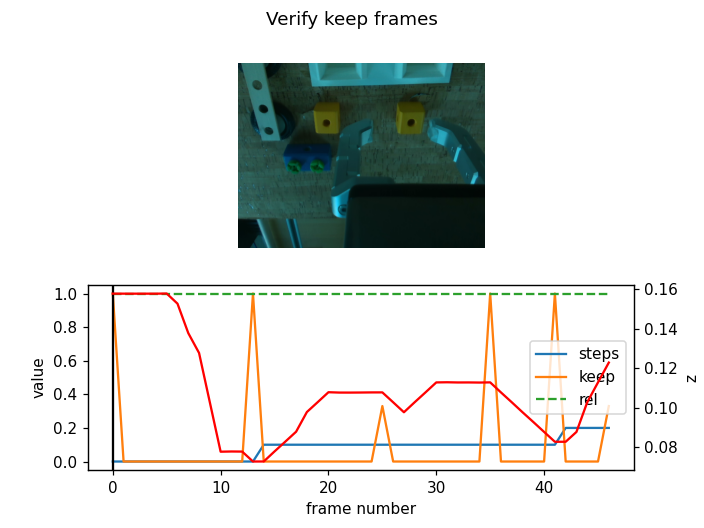

interactive(children=(IntSlider(value=0, description='w', layout=Layout(width='70%'), max=46), Output()), _dom…

In [62]:
def keep2plot2(keep):
    arr = np.zeros(len(gripper_actions))
    for k,v in keep.items():
        if v["skip"] is False:
            arr[k] = 1.0
        else:
            arr[k] = 0.33
        if "anchor" in v and v["anchor"] == "rel":
            arr[k] = 0.1
        #arr[k] = 1.0 - min(v["grip_dist"], 5) * 0.1
    return arr

if interactive:
    fig, (ax, ax2) = plt.subplots(2, 1)
    fig.suptitle("Verify keep frames")
    line = ax.imshow(video_recording[0])
    ax.set_axis_off()
    #ax2.plot(gripper_width*10, label="grip raw")
    ax2.plot(segment_steps/10, label="steps")
    ax2.plot(keep2plot2(keep_cmb), label="keep")
    ax2r = ax2.twinx()
    ax2r.set_ylabel("z")
    ax2r.plot(z_values, label='z', color='r')
    #ax2.plot((gripper_actions+1)/2, label="gripper action")
    if servo_anchors:
        ax2.plot([a == -1 for a in servo_anchors], "--", label="rel")

    ax2.set_ylabel("value")
    ax2.set_xlabel("frame number")
    vline = ax2.axvline(x=2, color="k")
    ax2.legend()

    def update(w):
        if wp_names:
            print("frame name:", wp_names[w])
        vline.set_data([w, w], [0, 1])
        line.set_data(video_recording[w])
        fig.canvas.draw_idle()
        if w in keep_cmb:
            print(keep_cmb[w])
            print()
    slider_w = widgets.IntSlider(min=0, max=max_frame, step=1, value=0,
                                 layout=Layout(width='70%'))
    interact(update, w=slider_w)


In [55]:
def get_gripper_close_open_locations():
    first_close = gripper_actions.tolist().index(-1)
    print("first_close", first_close)
    tmp_open = gripper_actions.copy()
    tmp_open[:first_close] = -1
    first_open = tmp_open.tolist().index(1)
    print("first_open:", first_open)
    
    return first_close, first_open


first_close, first_open = get_gripper_close_open_locations()


first_close 14
first_open: 42


In [56]:
import open3d as o3d

bbox_ext = 0.02

# keep_frames = [911]
# bbox_ext = np.array([.08, 0.08, .005])

def get_bbox(img_idx, ps, bbox_ext):
    # this is a pixel point between the grippers (where the object is located)
    t_tcp_robot = playback[img_idx].robot.get_tcp_pose()
    t_tcp_cam = playback[img_idx].cam.get_extrinsic_calibration()    
    trf = t_tcp_robot @ t_tcp_cam
    
    cam = playback[img_idx].cam
    img, depth = cam.get_image()
    pointcloud = cam.compute_pointcloud(depth, img)  # in camera coords
    
    # figure out pixel assignments
    far_val = 10
    u_crd, v_crd = np.where(np.logical_and(depth > 0, depth < far_val))
    
    pointcloud_idx = np.zeros(depth.shape, dtype=int)
    
    # what we are looking for f(x,y) -> pointcloud idx
    pointcloud_idx[u_crd, v_crd] = np.arange(len(pointcloud))
    pt_idx = pointcloud_idx[ps[0], ps[1]]
    
    point_before = pointcloud[pt_idx]
    
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(pointcloud[:, :3])
    if pointcloud.shape[1] == 6:
        pc.colors = o3d.utility.Vector3dVector(pointcloud[:, 3:6])
        
    pc.transform(trf)
    
    # create bounding box for cropping
    print("setting bbox.")
    point_after = pc.select_by_index([pt_idx]).points[0]
    min_bound = point_after - bbox_ext
    max_bound = point_after + bbox_ext
    print(type(point_after))

    # crop around selected shape
    print(pointcloud[pt_idx])
    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=min_bound, max_bound=max_bound)   
    
#     o3d.visualization.draw_geometries([pc, bbox])
    return bbox

# bbox_auto = get_object_point(first_open)


In [59]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
demo_index = 0
t_tcp_cam = playback[0].cam.get_extrinsic_calibration()

# get first open and close
# get bboxes for each
bbox_object = get_bbox(first_close, [178, 425], 0.02)
bbox_cube = get_bbox(first_open, [117, 493], np.array([0.1, 0.1, 0.005]))

seg_images = {}
fg_obj = {}

pcl_list = []
for i, v in keep_cmb.items():
    print("i:", i)
    #if v['skip'] == True:
    #    continue
    
    # load the image
    cam = playback[i].cam
    img, depth = cam.get_image()
    pointcloud = cam.compute_pointcloud(depth, img)  # in camera coords
    
    # Transform to world
    t_tcp_robot = playback[i].robot.get_tcp_pose()
    trf = t_tcp_robot @ t_tcp_cam
    
    # figure out pixel assignments
    far_val = 10
    u_crd, v_crd = np.where(np.logical_and(depth > 0, depth < far_val))
    
    pointcloud_idx = np.zeros(depth.shape, dtype=int)
    # what we are looking for f(x,y) -> pointcloud idx
    pointcloud_idx[u_crd, v_crd] = np.arange(len(pointcloud))
    
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(pointcloud[:, :3])
    if pointcloud.shape[1] == 6:
        pc.colors = o3d.utility.Vector3dVector(pointcloud[:, 3:6])
        
    pc.transform(trf)
    
    # choose bbox_object or bbox_cube 
    if i <= first_close:
        bbox = bbox_object
        object_id = 1
    else:
        bbox = bbox_cube
        object_id = 2
        
    # Get Segmentation Mask
    inliers = bbox.get_point_indices_within_bounding_box(pc.points)
    print("bbox crop", len(inliers))
    in_u = u_crd[inliers]
    in_v = v_crd[inliers]
    
    seg_image = np.zeros(depth.shape, dtype=int)
    seg_image[in_u, in_v] = object_id
    seg_images[i] = seg_image
    fg_obj[i] = object_id
    
    #print(inliers)
#     tmp = img.copy()
#     tmp[np.logical_not(seg_image)] = 255.
#     plt.imshow(tmp)
#     plt.show()
    
    pcl_list.append(bbox)
    pcl_list.append(pc)
#     break
    
# o3d.visualization.draw_geometries(pcl_list)

# turn seg_images, fg_obj into lists, with None for ignored frames
# save liststs.

masks_list = [None for _ in range(len(rec))]
fg_obj_tmp = [None for _ in range(len(rec))]

for k, v in seg_images.items():
    masks_list[k] = v
    fg_obj_tmp[k] = fg_obj[k]
    
mask_fn = './servo_mask.npz'
np.savez_compressed(mask_fn, mask=masks_list, fg=fg_obj_tmp)
print("Saved to", mask_fn)

setting bbox.
<class 'numpy.ndarray'>
[ 0.03361326 -0.0191188   0.19494927  0.28235294  0.14901961  0.05490196]
setting bbox.
<class 'numpy.ndarray'>
[ 0.05709762 -0.039771    0.20196842  0.71764706  0.77254902  0.78823529]
i: 0
bbox crop 0
i: 3
bbox crop 2706
i: 13
bbox crop 7763
i: 22
bbox crop 8999
i: 25
bbox crop 7589
i: 33
bbox crop 7190
i: 35
bbox crop 6854
i: 41
bbox crop 8055
i: 46
bbox crop 8659
Saved to ./servo_mask.npz


0	0
3	1
13	3
22	3
25	2
33	2
35	2
41	3
46	3


<IPython.core.display.Javascript object>


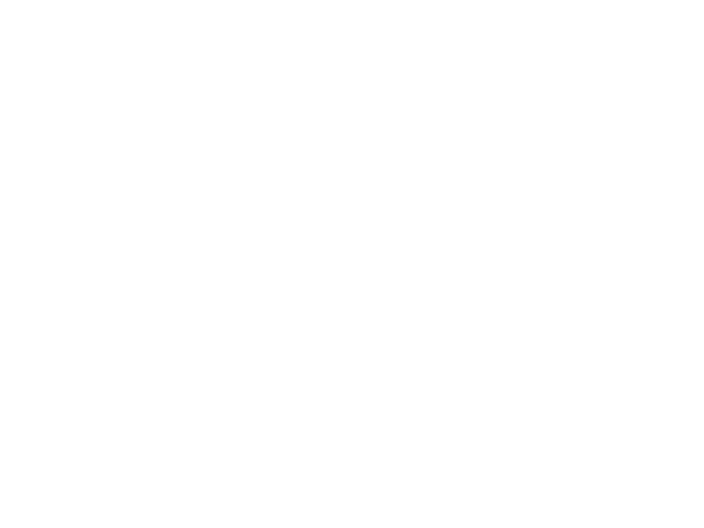

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='70%'), max=8), Output()), _dom_…

In [60]:
if  interactive:
    tmp = np.load(mask_fn, allow_pickle=True)
    
    servo_indexes = []
    for k, v in keep_cmb.items():
        servo_indexes.append(k)

        percent_fg = np.mean(tmp["mask"][k] == tmp["fg"][k])*100
        print(f"{k}\t{percent_fg:.0f}")
    
    first = servo_indexes[0]
    fig, ax = plt.subplots(1)
    handle = ax.imshow(tmp["mask"][first] == tmp["fg"][first])
    ax.set_axis_off()
    
    def update(i):
        i2 = servo_indexes[i]
        image = video_recording[i2].copy()
        mask = tmp["mask"][i2] == tmp["fg"][i2]
        print(mask.shape)
        print(round(np.mean(mask)*100), "% fg, mask shape", mask.shape)
        image[np.logical_not(mask)] = 255, 255, 255
        handle.set_data(image)
        fig.canvas.draw_idle()

    slider_i2 = widgets.IntSlider(min=0, max=len(servo_indexes)-1, step=1, value=0,
                                 layout=Layout(width='70%'))
    interact(update, i=slider_i2)

In [ ]:
tmp = np.load(mask_fn, allow_pickle=True)
print(tmp["mask"][k])


In [ ]:
tmp = np.load(mask_fn)
for k, info in keep_cmb.items():
    mask = tmp["mask"][k] == tmp["fg"][k]
    if servo_anchors[k] == -1:
        pixels_segmented = np.sum(mask==True)
        if pixels_segmented > 0:
            logging.warning("Keyframe %s: segmentation given for relative motion.", k)
    else:
        percent_segmented = np.mean(mask==True)
        if percent_segmented < .01:
            logging.warning("Keyframe %s: low fraction of image segmented for keyframe %s", k, round(percent_segmented*100))
    
print(f"Checking {mask_fn} passed.")  

In [ ]:
fg_obj_tmp

In [ ]:
mask_list = [None for i in range(len(rec))]
for key in seg_images:
    mask_list[key] = seg_images[key]
    
fg_obj = []

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
demo_index = 0
t_tcp_cam = playback[0].cam.get_extrinsic_calibration()

pcl_list = []
keep_frames = [18, 911]

for i in keep_frames:
    print("i:", i)
    # get the camera position
    t_tcp_robot = playback[i].robot.get_tcp_pose()
    trf = t_tcp_robot @ t_tcp_cam
    
    # load the image
    cam = playback[i].cam
    img, depth = cam.get_image()
    
    pointcloud = cam.compute_pointcloud(depth, img)  # in camera coords
    
    # figure out pixel assignments
    far_val = 10
    u_crd, v_crd = np.where(np.logical_and(depth > 0, depth < far_val))
    
    pointcloud_idx = np.zeros(depth.shape, dtype=int)
    # what we are looking for f(x,y) -> pointcloud idx
    pointcloud_idx[u_crd, v_crd] = np.arange(len(pointcloud))
    pt_idx = pointcloud_idx[ps[0], ps[1]]
    
    point_before = pointcloud[pt_idx]
    
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(pointcloud[:, :3])
    if pointcloud.shape[1] == 6:
        pc.colors = o3d.utility.Vector3dVector(pointcloud[:, 3:6])
        
    pc.transform(trf)
    
    # create bounding box for cropping
    if i == keep_frames[0]:
        print("setting bbox.")
        point_after = pc.select_by_index([pt_idx]).points[0]
        min_bound = point_after - bbox_ext
        max_bound = point_after + bbox_ext
        print(type(point_after))

        # crop around selected shape
        print(pointcloud[pt_idx])
        bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=min_bound, max_bound=max_bound)
    
    # crop
    #pc = pc.crop(bbox)
    
    inliers = bbox_auto.get_point_indices_within_bounding_box(pc.points)
    in_u = u_crd[inliers]
    in_v = v_crd[inliers]
    
    seg_image = np.zeros(depth.shape, dtype=bool)
    seg_image[in_u, in_v] = True
    
    #print(inliers)
    tmp = img.copy()
    tmp[np.logical_not(seg_image)] = 255.
    plt.imshow(tmp)
    plt.show()
    
    pcl_list.append(bbox_auto)
    pcl_list.append(pc)
    break
    
o3d.visualization.draw_geometries(pcl_list)